Crea una classe di backtesting, del tutto analoga a quella per SMA, che funzioni con le bande di Bollinger. Questa classe ha un due parametri numerici: la finestra che è un int e il numero di deviazioni standard che è un float. Durante l'ottimizzazione consiglio di testare le deviazioni standard tra 1 e 5 con steps di 0.1. Non potete usare il range perché funziona solo con interi, ma potete usare range(10,50,1) e poi dividere per 10.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import tpqoa
api = tpqoa.tpqoa("oanda.cfg")
from itertools import product

In [2]:
class BandeBollingerBacktester():
    
    def __init__(self, symbol, window, numdevst, start, end):
        #questo underscore _symbol, _SMA_s indica che la variabile non viene toccata dallesterno e sarebbe protetta
        self._symbol = symbol
        self._window=window
        self._numdevst=numdevst
        self._start=start
        self._end=end
        self._results=None #none eh variabile vuota
        self.get_data()
        self.prepare_data()
      
    def get_data(self):
        df=api.get_history(instrument=self._symbol, start=self._start, end=self._end, granularity="H6", price="B").c.to_frame()
        df["logret"]=np.log(df.c/df.c.shift(1))
        self._data=df
        

    def prepare_data(self):
        self._data["SMA"]=self._data.c.rolling(self._window).mean()
        self._data["devst"]=self._data.c.rolling(self._window).std()
        self._data["lower"]=self._data.SMA-(self._numdevst*self._data.devst)
        self._data["upper"]=self._data.SMA+(self._numdevst*self._data.devst)
        
        
    def set_parameters(self, window=None, numdevst=None):
        if window is not None:
            self._window=window
            self._data["SMA"]=self._data.c.rolling(self._window).mean()
            self._data["devst"]=self._data.c.rolling(self._window).std()
        if numdevst is not None:
            self._numdevst=numdevst
            self._data["lower"]=self._data.SMA-(self._numdevst*self._data.devst)
            self._data["upper"]=self._data.SMA+(self._numdevst*self._data.devst) 
        
        
    def test_strategy(self):   
        df2 = self._data.dropna().copy() # copia fisica, non puntatore
        df2["position"]=np.where(df2.c<df2.lower, +1, np.nan)
        df2["position"]=np.where(df2.c>df2.upper, -1, df2["position"])
        df2["position"]=np.where(np.sign(df2.c-df2.SMA) != np.sign((df2.c-df2.SMA).shift(1)), 0, df2["position"])
        df2["position"]=df2.position.ffill()
        df2["strategy"]=df2.position.shift(1)*df2.logret
        df2["cumlogret"]= df2.logret.cumsum()
        df2["cumstrategy"]=df2.strategy.cumsum()
        performance = df2.strategy.sum()
        overperformance=performance-df2.cumlogret.iloc[-1]
        maxdrawdown = (df2.strategy.cummax()-df2.strategy.cumsum()).max()
        self._results=df2 #se voglio far un grafico, mi serve
        return round(performance,6), round(overperformance,6), round(maxdrawdown,6)
    
    
#fino a qua avevo fatto prima dalla lezione di venerdi 05.11

    def plot_results(self):
        if self._results is None:
            print("Devi prima chiamare test_strategy()")
        else:
            title="{}    Windowrange = {}     Numdevstrange = {}".format(self._symbol,self._window,self._numdevst)
            self._results[["cumlogret","cumstrategy"]].plot(figsize=(25,15))
            plt.legend(fontsize=18)
            plt.title(title,fontsize=22)
            plt.show()
    
    def optimize_strategy(self, windowrange, numdevstrange):
        tuples=list(product(range(windowrange[0], windowrange[1]), range(numdevstrange[0],numdevstrange[1])))
        results=[]
        for t in tuples:
            self.set_parameters(t[0],t[1]/10)
            results.append(self.test_strategy()[0])
        
        best_performance = np.max(results)
        best_combination = tuples[np.argmax(results)]
        
        output=pd.DataFrame(tuples,columns=["window", "numdevst/10"])
        output["performance"]=results
        self._results_output=output
        return best_performance, best_combination

In [3]:
testerClass = BandeBollingerBacktester(symbol = "EUR_USD", window=30, numdevst=2.0, start = "2018-10-10", end = "2021-10-10")

In [4]:
testerClass.test_strategy()

(0.044333, 0.034676, 0.010299)

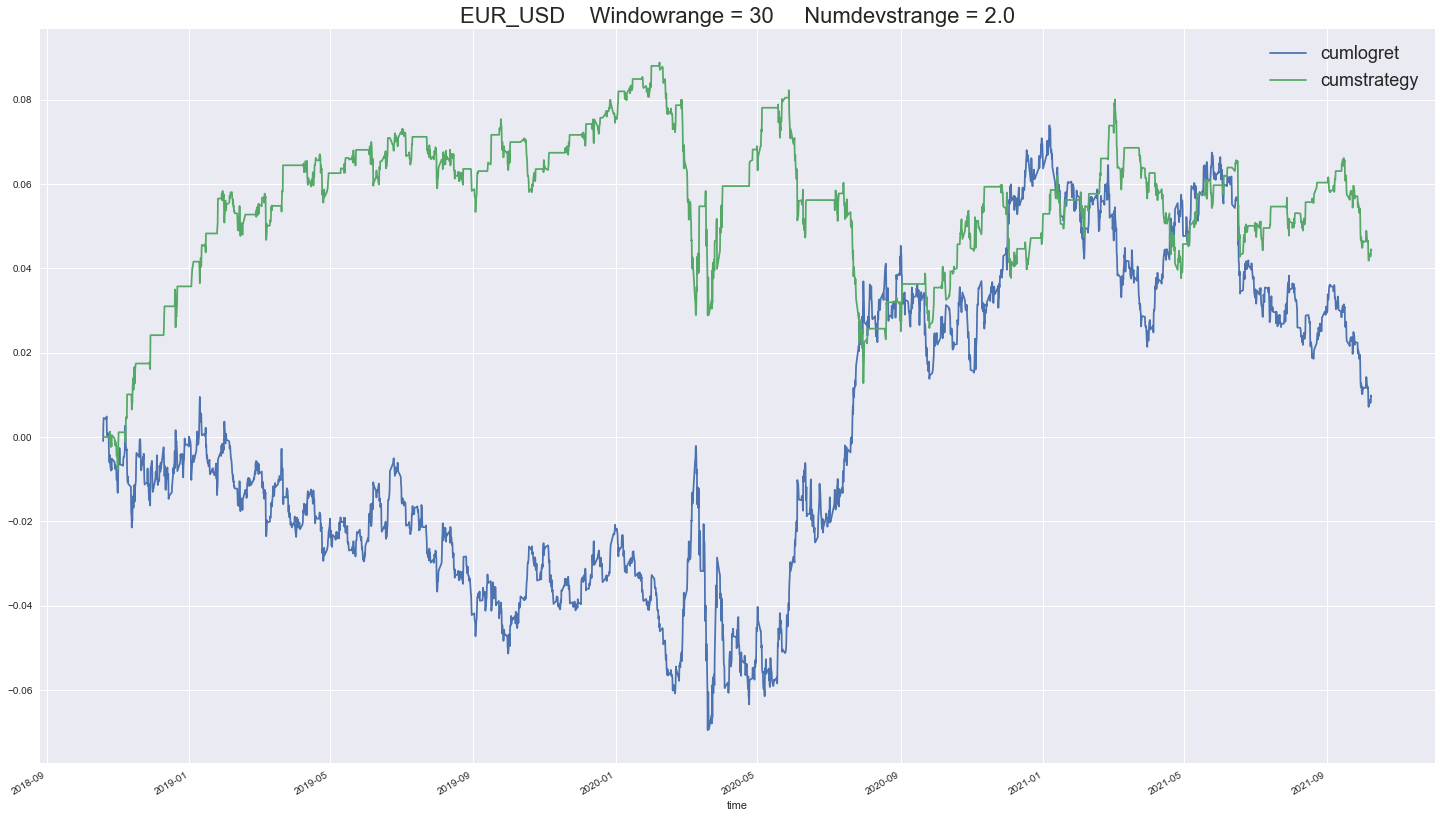

In [5]:
testerClass.plot_results()

In [6]:
testerClass.optimize_strategy((10,50),(10,50))   

(0.124023, (45, 12))

# Adesso si considerano le comissioni

In [7]:
class BandeBollingerBacktesterCosts():
    
    def __init__(self, symbol, window, numdevst, start, end):
        #questo underscore _symbol, _SMA_s indica che la variabile non viene toccata dallesterno e sarebbe protetta
        self._symbol = symbol
        self._window=window
        self._numdevst=numdevst
        self._start=start
        self._end=end
        self._results=None #none eh variabile vuota
        self.get_data()
        self.prepare_data()
      
    def get_data(self):
        df=api.get_history(instrument=self._symbol, start=self._start, end=self._end, granularity="H6", price="B").c.to_frame()
        df["logret"]=np.log(df.c/df.c.shift(1))
        self._data=df
        

    def prepare_data(self):
        self._data["SMA"]=self._data.c.rolling(self._window).mean()
        self._data["devst"]=self._data.c.rolling(self._window).std()
        self._data["lower"]=self._data.SMA-(self._numdevst*self._data.devst)
        self._data["upper"]=self._data.SMA+(self._numdevst*self._data.devst)
        
    def set_parameters(self, window=None, numdevst=None):
        if window is not None:
            self._window=window
            self._data["SMA"]=self._data.c.rolling(self._window).mean()
            self._data["devst"]=self._data.c.rolling(self._window).std()
        if numdevst is not None:
            self._numdevst=numdevst
            self._data["lower"]=self._data.SMA-(self._numdevst*self._data.devst)
            self._data["upper"]=self._data.SMA+(self._numdevst*self._data.devst) 
        
        
    def test_strategy(self):   
        df2 = self._data.dropna().copy() # copia fisica, non puntatore
        comm=0.0015
        spread=0.00008/df2.c.mean()
        df2["position"]=np.where(df2.c<df2.lower, +1, np.nan)
        df2["position"]=np.where(df2.c>df2.upper, -1, df2["position"])
        df2["position"]=np.where(np.sign(df2.c-df2.SMA) != np.sign((df2.c-df2.SMA).shift(1)), 0, df2["position"])
        df2["position"]=df2.position.ffill()
        df2["transactions"]=abs(df2.position-df2.position.shift(1))
        df2["strategy"]=df2.position.shift(1)*df2.logret
        df2["cumlogret"]= df2.logret.cumsum()
        df2["strategyNetto"]=(df2.strategy)-(df2.transactions*(comm+(spread/2)))
        df2["cumstrategyNetto"]= df2.strategyNetto.cumsum()
        performance = df2.strategyNetto.sum()
        overperformance=performance-df2.cumlogret.iloc[-1]
        maxdrawdown = (df2.strategy.cummax()-df2.strategy.cumsum()).max()
        self._results=df2 #se voglio far un grafico, mi serve
        return round(performance,6), round(overperformance,6), round(maxdrawdown,6)
    
    def plot_results(self):
        if self._results is None:
            print("Devi prima chiamare test_strategy()")
        else:
            title="{}    Windowrange = {}     Numdevstrange = {}".format(self._symbol,self._window,self._numdevst)
            self._results[["cumlogret","cumstrategyNetto"]].plot(figsize=(25,15))
            plt.legend(fontsize=18)
            plt.title(title,fontsize=22)
            plt.show()
    
    def optimize_strategy(self, windowrange, numdevstrange):
        tuples=list(product(range(windowrange[0], windowrange[1]), range(numdevstrange[0],numdevstrange[1])))
        results=[]
        for t in tuples:
            self.set_parameters(t[0],t[1]/10)
            results.append(self.test_strategy()[0])
        
        best_performance = np.max(results)
        best_combination = tuples[np.argmax(results)]
        
        output=pd.DataFrame(tuples,columns=["window", "numdevst/10"])
        output["performance"]=results
        self._results_output=output
        return best_performance, best_combination

In [8]:
testerClassCosts = BandeBollingerBacktesterCosts(symbol = "EUR_USD", window=30, numdevst=2.0, start = "2018-10-10", end = "2021-10-10")


In [9]:
testerClassCosts.test_strategy()

(-0.193569, -0.203226, 0.010299)

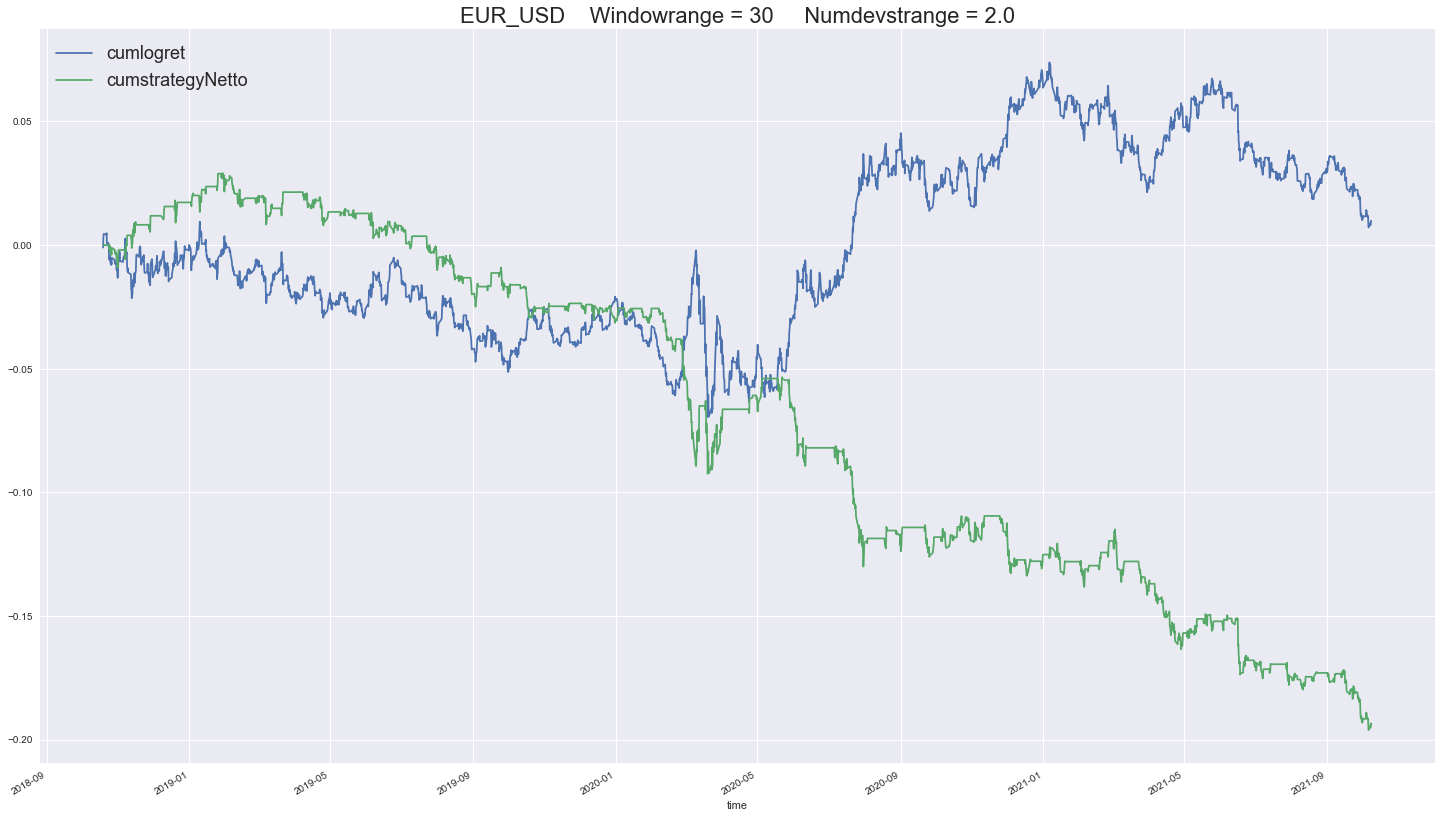

In [10]:
testerClassCosts.plot_results()

In [11]:
testerClassCosts.optimize_strategy((10,50),(10,50))   

(0.020345, (28, 29))

# ForwardTesting - senza commissioni 

In [12]:
trainer=BandeBollingerBacktester(symbol = "EUR_USD", window=30, numdevst=2.0, start="2008-10-10",end="2019-10-10")

In [13]:
trainer.test_strategy()

(0.077537, 0.282029, 0.137726)

In [14]:
trainer.optimize_strategy((10,50),(10,50)) 

(0.436978, (31, 11))

In [15]:
# prendere i parametri ottimi della cellula anteriore e mettere qua su window e numdevst
# window=31  numdevst=11
tester = BandeBollingerBacktester(symbol = "EUR_USD", window=31, numdevst=11.0, start="2019-10-11",end="2021-10-27")

In [16]:
tester._results

In [17]:
tester.test_strategy()
#risultato: un disastro

(0.0, -0.040254, -0.0)

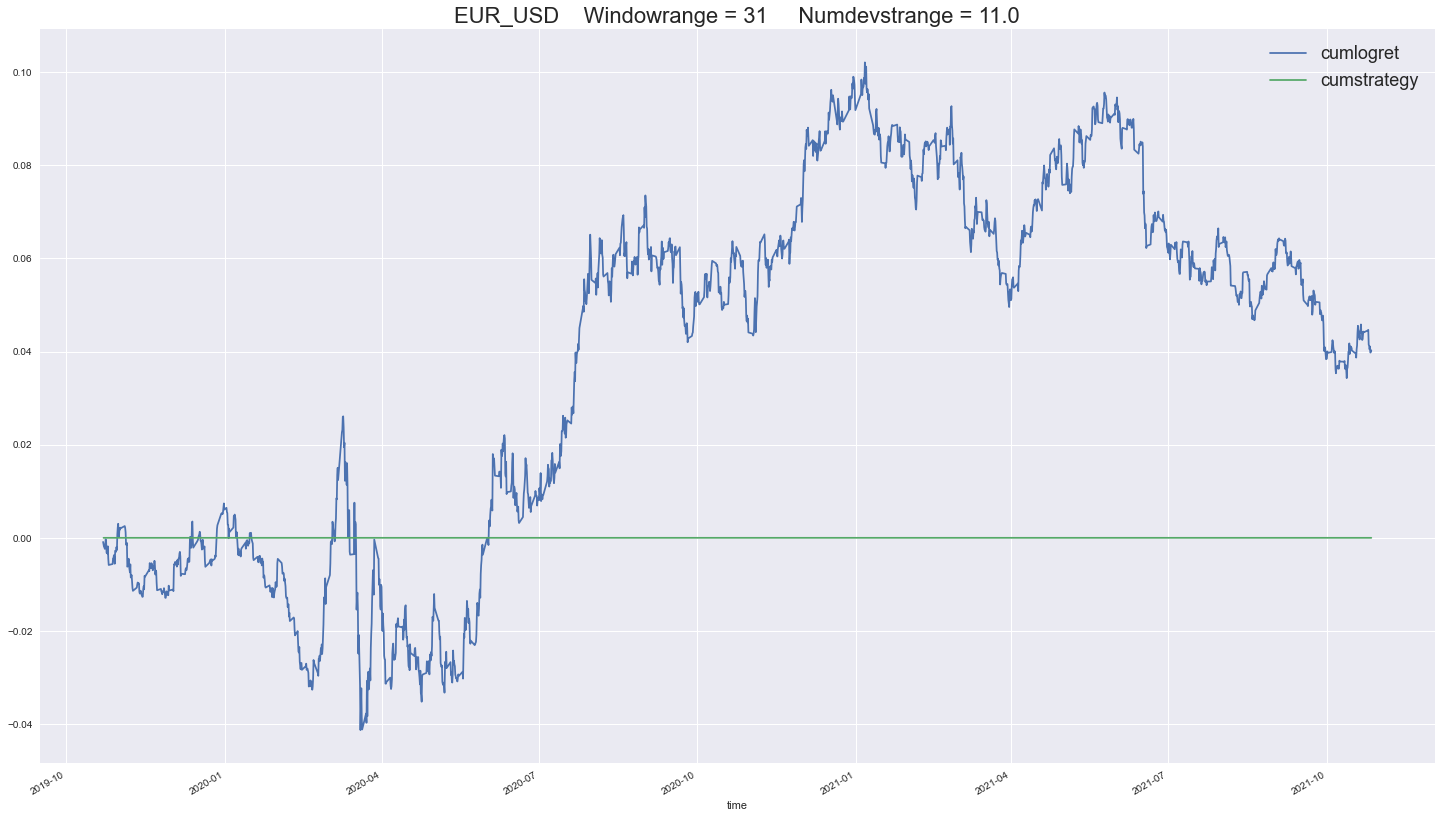

In [18]:
tester.plot_results()

In [19]:
# i parametri dell otimizer sul trainer e quegli che vengono qua sono almenno simili?
tester.optimize_strategy((10,50), (10,50)) 

(0.040484, (16, 25))

In [20]:
# I parametri suggeriti dal procedimento di training sono 31,11 (window, devst) e 
# i parametri ottenuti nel testing sono 16,25 per lo stesso range di parametri. Quindi abbastanza diversi. 

# ForwardTesting - con commissioni 

In [21]:
trainerCosts=BandeBollingerBacktesterCosts(symbol = "EUR_USD", window=30, numdevst=2.0, start="2008-10-10",end="2019-10-10")

In [22]:
trainerCosts.test_strategy()

(-0.872206, -0.667714, 0.137726)

In [23]:
trainerCosts.optimize_strategy((10,50), (10,50)) 

(0.022713, (40, 41))

In [24]:
# prendere i parametri ottimi della cellula anteriore e mettere qua su window e numdevst
# window=40  numdevst=41
testerCosts=BandeBollingerBacktesterCosts(symbol = "EUR_USD", window=40, numdevst=41.0, start="2019-10-11",end="2021-10-27")

In [25]:
testerCosts.test_strategy()
# risultato: un disastro

(0.0, -0.043454, -0.0)

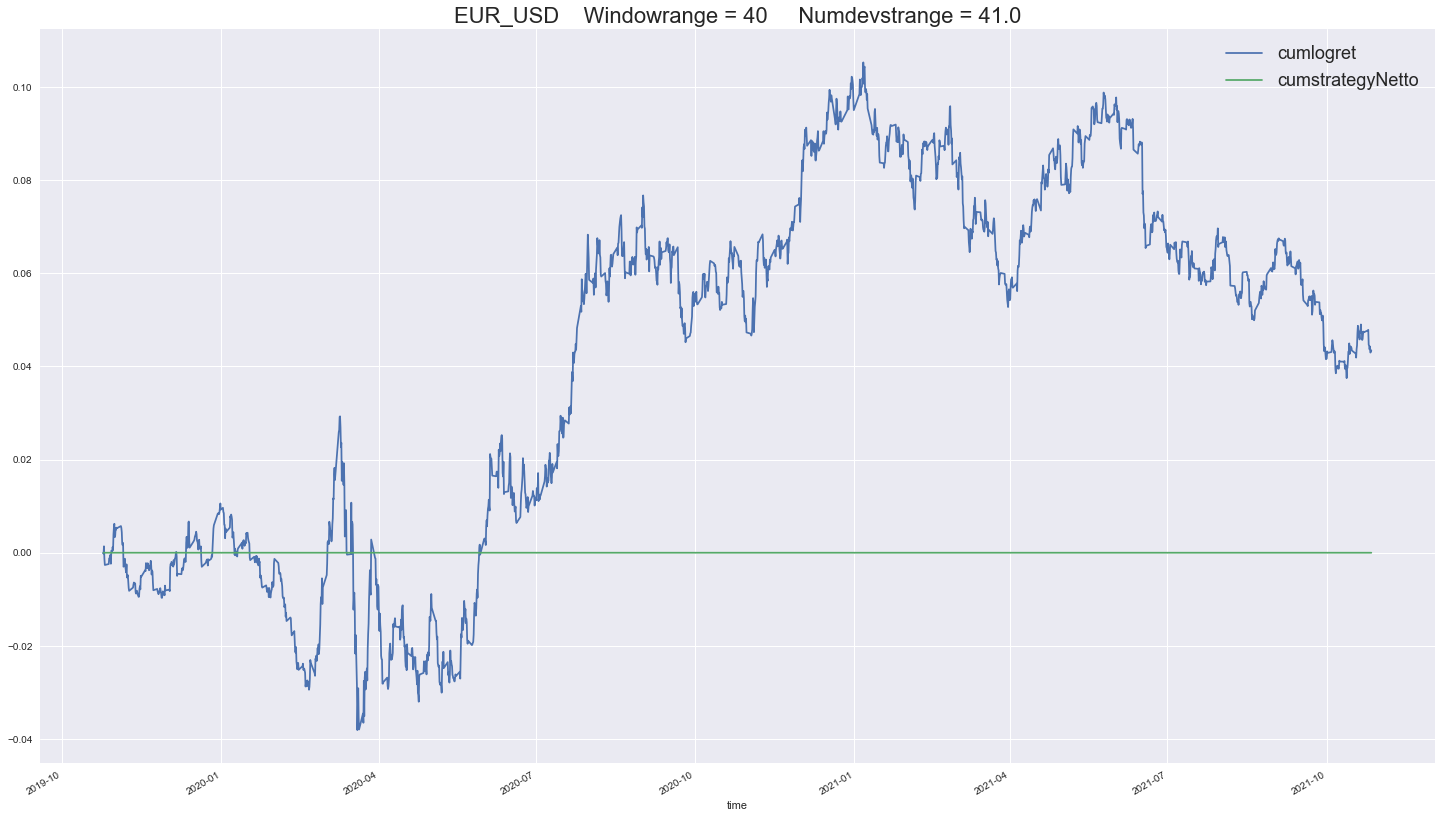

In [26]:
testerCosts.plot_results()

In [27]:
# i parametri dell otimizer sul trainer e quegli che vengono qua sono almenno simili?
testerCosts.optimize_strategy((10,50), (10,50)) 

(0.005307, (25, 34))

In [28]:
# I parametri suggeriti dal procedimento di training sono 40,41 (window, devst) e 
# i parametri ottenuti nel testing sono 25,34 per lo stesso range di parametri. Quindi almenno la finestra, 
# abbastanza diversa. 

# do not consider


 #optimize strategy ultima versione, prende i dati dalla classe, finestra e numero devst:
    def optimize_strategy(self):
        tuples = []
        results=[]
        for i in range(1,self._window):
            for j in range(1,self._numdevst):
                dummytuple=(i,j)
                tuples.append(dummytuple)
        for t in tuples:
            self.set_parameters(t[0],t[1])
            results.append(self.test_strategy()[0])
        best_performance = np.max(results)
        best_combination = combinations[np.argmax(results)]
        return best_performance, best_combination

    #optimize strategy rende i dati dalla classe, finestra e numero devst:
        def optimize_strategy(self):
        tuples = []
        results=[]
        for i in range(1,self._window):
            for j in range(1,self._numdevst):
                dummytuple=(i,j)
                tuples.append(dummytuple)
        for t in tuples:
            self.set_parameters(t[0],t[1])
            results.append(self.test_strategy()[0])
        best_performance = np.max(results)
        best_combination = combinations[np.argmax(results)]
        return best_performance, best_combination





     #optimize strategy 04.11. 20ore che funziona
        def optimize_strategy(self, windowrange, numdevstrange):
        results = []
        combinations=list(product(range(windowrange[0],windowrange[1]),range(numdevstrange[0],numdevstrange[1]) ))
        for comb in combinations:
            self.set_parameters(comb[0],comb[1])
            results.append(self.test_strategy()[0])
        best_performance = np.max(results)
        best_combination = combinations[np.argmax(results)]
        return best_performance, best_combination
    
    
    
    #test strategy 04.11. 20ore che funziona
    
        def test_strategy(self):   
        df2 = self._data.dropna().copy() # copia fisica, non puntatore
        df2["position"]=np.where(df2.c<df2.lower, +1, np.nan)
        df2["position"]=np.where(df2.c>df2.upper, -1, df2["position"])
        df2["position"]=np.where(np.sign(df2.c-df2.SMA) != np.sign((df2.c-df2.SMA).shift(1)), 0, 
                                        df2["position"])
        df2["position"]=df2.position.ffill()
        df2["strategy"]=df2.position.shift(1)*df2.logret
        df2["cumlogret"]= df2.logret.cumsum()
        performance = df2.strategy.sum()
        overperformance=performance-df2.cumlogret.iloc[-1]
        maxdrawdown = (df2.strategy.cummax()-df2.strategy.cumsum()).max()
        self.results=df2 #se voglio far un grafico, mi serve
        return round(performance,6), round(overperformance,6), round(maxdrawdown,6)
        
        
        
        
        
        
        
        columnnames=["logret"]
        for i in range(1,self._window+1):
            self._data["SMA"]=self._data.c.rolling(self._window).mean()
        self._data["devst"]=self._data.c.rolling(self._window).std()
        self._data["lower"]=self._data.SMA-(self._numdevst*self._data.devst)
        self._data["upper"]=self._data.SMA+(self._numdevst*self._data.devst)
        self._data["position"]=np.where(self._data.c<self._data.lower, +1, np.nan)
        self._data["position"]=np.where(self._data.c>self._data.upper, -1, self._data["position"])
        self._data["position"]=np.where(np.sign(self._data.c-self._data.SMA) != np.sign((self._data.c-self._data.SMA).shift(1)), 0, 
                                        self._data["position"])
        self._data["position"]=self._data.position.ffill()
            
            
            
            
            self._data["SMA"+str(i)]=self._data.c.rolling(self._window).mean()
            self._data["devst"+str(i)]=self._data.c.rolling(self._window).std()
            self._data["lower"+str(i)]=self._data.SMA-(self._numdevst*self._data.devst)
            self._data["upper"+str(i)]=self._data.SMA+(self._numdevst*self._data.devst)
            self._data["position"+str(i)]=np.where(self._data.c<self._data.lower, +1, np.nan)
            self._data["position"+str(i)]=np.where(self._data.c>self._data.upper, -1, self._data["position"])
            self._data["position"+str(i)]=np.where(np.sign(self._data.c-self._data.SMA) != np.sign((self._data.c-self._data.SMA).shift(1)), 0, 
                                        self._data["position"])
        self._data["position"]=self._data.position.ffill()
            df2["position"+str(i)] = np.where(self._data["logret"].rolling(i).mean() > 0, -1 ,+1)
            df2["contrarian" + str(i)]=self._data["position"+str(i)].shift(1)*self._data.logret
            columnnames.append("contrarian"+str(i))
        return self._data[columnnames].sum()
    
    
    
    
    
    
    #sunday 7.11 last version
        def optimize_strategy(self):
        #combinations=list(products())
        tuples = []
        results=[]
        for i in range(1,self._window):
            for j in range(1,self._numdevst):
                dummytuple=(i,j)
                tuples.append(dummytuple)
        for t in tuples:
            self.set_parameters(t[0],t[1])
            results.append(self.test_strategy()[0])
        best_performance = np.max(results)
        best_combination = combinations[np.argmax(results)]
        return best_performance, best_combination
    
    
    
    
    
    
    
    
    def optimize_strategy(df, window, numdev):
    tuples = []
    results=[]
    for i in range(1,self._window):
            for j in range(1,self._numdevst):
                dummytuple=(i,j)
                tuples.append(dummytuple)
        for t in tuples:
            self.set_parameters(t[0],t[1])
            results.append(self.test_strategy()[0])
        best_performance = np.max(results)
        best_combination = combinations[np.argmax(results)]
        return best_performance, best_combination
    
    
    
    
    
    
    # ultima versiona domenica 7.11 funziona:
        def test_strategy(self):   
        #df2 = self._data.dropna().copy() # copia fisica, non puntatore
        self._data["position"]=np.where(self._data.c<self._data.lower, +1, np.nan)
        self._data["position"]=np.where(self._data.c>self._data.upper, -1, self._data["position"])
        self._data["position"]=np.where(np.sign(self._data.c-self._data.SMA) != np.sign((self._data.c-self._data.SMA).shift(1)), 0, 
                                        self._data["position"])
        self._data["position"]=self._data.position.ffill()
        self._data["strategy"]=self._data.position.shift(1)*self._data.logret
        self._data["cumlogret"]= self._data.logret.cumsum()
        self._data["cumstrategy"]=self._data.strategy.cumsum()
        performance = self._data.strategy.sum()
        overperformance=performance-self._data.cumlogret.iloc[-1]
        maxdrawdown = (self._data.strategy.cummax()-self._data.strategy.cumsum()).max()
        self.results=df2 #se voglio far un grafico, mi serve
        return round(performance,6), round(overperformance,6), round(maxdrawdown,6)
    
    
    
    for j in range(1,6,1):
    for i in range(10,110,10):
        if (j+i/100)>5: 
            break
        else:    
            df["SMA"+str(j+i/100)]=""
            df["SMA"+str(j+i/100)]=(df.c.rolling(j).mean())+(df.c.rolling(i).mean())/10
            
            
            
        #domenica 15ore versione di prepare data che funziona ma include tutte le posizione inutile 
    def prepare_data(self):
        self._data["SMA"]=self._data.c.rolling(self._window).mean()
        self._data["devst"]=self._data.c.rolling(self._window).std()
        self._data["lower"]=self._data.SMA-(self._numdevst*self._data.devst)
        self._data["upper"]=self._data.SMA+(self._numdevst*self._data.devst)
        # oko: should this whole positions be here? does it make sense?
 #       self._data["position"]=np.where(self._data.c<self._data.lower, +1, np.nan)
  #      self._data["position"]=np.where(self._data.c>self._data.upper, -1, self._data["position"])
   #     self._data["position"]=np.where(np.sign(self._data.c-self._data.SMA) != np.sign((self._data.c-self._data.SMA).shift(1)), 0, 
    #                                    self._data["position"])
     #   self._data["position"]=self._data.position.ffill()
        
        